# Exploration04. 작사가 만들기
- RNN (LSTM)

In [1]:
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 읽어오기

In [2]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


## 데이터 정제하고 모으기

데이터 정제하기

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("I@ am     a ;;;;;good boy"))

<start> i am a good boy <end>


정규표현식 : https://myeonguni.tistory.com/1555  
r" \1 " : 원래 문장을 가져오는데 ([?.!,¿])이 기호 양쪽을 한칸씩 띄어쓰기, https://stackoverflow.com/questions/20802056/python-regular-expression-1/20802130

정제된 문장들을 corpus에 모으기

In [4]:
corpus = []

for sentence in raw_corpus:  # raw_corpus : 라인 단위로 끊은 전체 글
    if len(sentence) == 0: continue   # 빈칸으로 된 문장 제외
    if sentence[-1] == ":": continue  # 콜론(:)으로 끝나는 문장 제외
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:3]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>']

## 문장에서 단어를 추출하여 토큰으로 만들기

In [1]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    print(tensor,tokenizer)
    return tensor, tokenizer

# tensor, tokenizer = tokenize(corpus)

In [6]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


토큰의 인덱스 순서는 토큰의 빈도수에 의해 결정됨  
https://wikidocs.net/31766

## 토큰 개수 15개 넘어가는 것 제외시키기

In [7]:
tensor[1]

[2, 17, 2639, 873, 4, 8, 11, 6043, 6, 329, 3]

In [8]:
tensor_temp = []
for i in tensor:
    if len(i) > 15:
        continue
    else:
        tensor_temp.append(i)

for문으로 토큰 갯수가 15개 초과인 시퀀스를 제외시킴

In [9]:
# tensor_temp

## 시퀀스 길이 통일하기

In [10]:
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor_temp, padding='post') 

padding='post'
- 시퀀스의 길이를 맞춰주기 위해 padding을 넣음
- post : 단어 뒷단의 부족한 부분을 0으로 채움
- pre-padding과 post-padding : https://blog.naver.com/qbxlvnf11/221945962124

## 소스 문장과 타겟 문장 만들기

In [11]:
tensor[4]

array([   2,    6, 3604,    4,    6, 2265,    3,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [12]:
len(tensor_temp)

156013

In [13]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    5   91  297   65   57    9  969 6042    3    0    0    0]
[  50    5   91  297   65   57    9  969 6042    3    0    0    0    0]


In [14]:
len(src_input)

156013

## 훈련데이터와 평가데이터 분리하기

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state=95)

x_train, x_test, y_train, y_test

In [17]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


In [18]:
enc_val.shape, dec_val.shape

((31203, 14), (31203, 14))

## 모델 만들기

![RNN](https://d3s0tskafalll9.cloudfront.net/media/images/E-12-4.max-800x600.png)

Embedding : https://casa-de-feel.tistory.com/28
- 단어를 벡터형태의 숫자들로 변환함
- 단어를 컴퓨터가 인식할 수 없기 때문에 임베딩을 이용하여 표현
- 벡터들을 이용하여 다른 단어들과 유사도를 계산해볼 수 있음

In [19]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1024
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

RNN 구조 : https://tykimos.github.io/2017/04/09/RNN_Getting_Started/

hidden_size : 은닉층의 unit, 은닉층의 뉴런수  
return_sequences : 출력 시퀀스 또는 전체 시퀀스에서 마지막 출력을 반환할지 여부. 기본값 : False .  
- 현재는 True이므로 시퀀스의 길이(토큰의 갯수)인 20개를 벡터로 변환하여 출력

## 모델 학습

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=10, validation_data=(enc_val, dec_val))

Epoch 1/10
3901/3901 [==============================] - 493s 121ms/step - loss: 2.8874 - val_loss: 2.5941
Epoch 2/10
3901/3901 [==============================] - 473s 121ms/step - loss: 2.3130 - val_loss: 2.3447
Epoch 3/10
3901/3901 [==============================] - 474s 122ms/step - loss: 1.8626 - val_loss: 2.2197
Epoch 4/10
3901/3901 [==============================] - 474s 121ms/step - loss: 1.5263 - val_loss: 2.1862
Epoch 5/10
3901/3901 [==============================] - 474s 122ms/step - loss: 1.3094 - val_loss: 2.2059
Epoch 6/10
3901/3901 [==============================] - 475s 122ms/step - loss: 1.1819 - val_loss: 2.2549
Epoch 7/10
3901/3901 [==============================] - 475s 122ms/step - loss: 1.1155 - val_loss: 2.2954
Epoch 8/10
3901/3901 [==============================] - 475s 122ms/step - loss: 1.0788 - val_loss: 2.3416
Epoch 9/10
3901/3901 [==============================] - 475s 122ms/step - loss: 1.0564 - val_loss: 2.3693
Epoch 10/10
3901/3901 [=======================

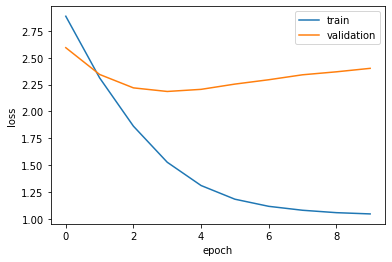

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])

### 최저 validation_loss = 2.1862 (Epoch=4 일 때)
- Epoch=5부터는 Overfitting

## 작사가 만들기

In [22]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> hello", max_len=20)

'<start> hello , how are you ? i m fine . cause i know <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> good bye", max_len=20)

'<start> good bye , good bye <end> '

In [28]:
generate_text(model, tokenizer, init_sentence="<start> kill", max_len=20)

'<start> kill the lights ! <end> '

## 결과

embedding_size와 hidden_size를 바꿔가면서 최저 validattion_loss를 찾아봄

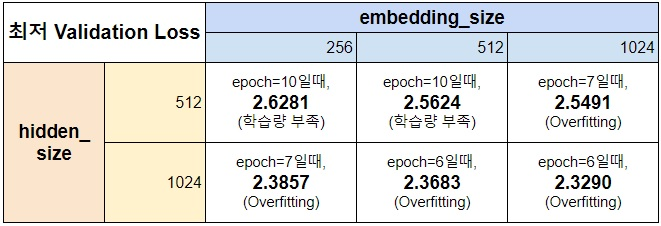

### 최저 validation_loss = 2.1862 (Epoch=4 일 때)
- embedding_size = 1024
- hidden_size = 2048
- Epoch=5부터는 Overfitting

### 모델이 제시한 단어에 맞게 문장을 잘 만들어냄

## 회고

### 1. 새로 알아갔던 점
 - 정규표현식을 깊숙히 알아갈 수 있는 시간이었음
 - keras의 여러 패키지를 알아볼 수 있었음

### 2. 흥미로웠던 점
 - embedding_size와 hidden_size만 변경하면서 validation_loss의 최소값을 찾아갔던 것
 - 문장을 토큰으로 분할하고 그 토큰을 vector로 구성하는 점이 흥미로웠음
 - RNN의 구성을 찾아보면서 좀 더 딥러닝을 좀 더 알아가는 것 같아 재밌었음

### 3. 아쉬웠던 점
 - 프로젝트 제출 설명에 '만약 결과가 다르다면 천천히 과정을 다시 살펴 동일한 결과를 얻도록 하세요'라는 문구 때문에 학습 데이터셋을 예시와 똑같이 맞추기 위해 1시간 40분을 소모했지만 꼭 그 수치를 맞출 필요가 없다는 것을 알았음

### 4. 앞으로의 다짐
 - 정교화된 텍스트 말고 영화 리뷰같은 글들도 RNN을 통해서 분석해보고 싶음